# Accessing Visual Behavior Ophys Data

## Tutorial overview

This Jupyter notebook covers the various methods for accessing the Allen Institute Visual Behavior Ophys dataset. We will go over how to request data, where it's stored, and what the various files contain. If you're having trouble downloading the data, or you just want to know more about what's going on under the hood, this is a good place to start.

This data release will not have a web interface for browsing through the released data, as with the [two-photon imaging Visual Coding dataset](http://observatory.brain-map.org/visualcoding). Instead, the data must be retrieved through the AllenSDK (Python 3.6+) or via requests sent to the **Amazon Web Services (AWS)** **Simple Storage Service (S3)** bucket (name: [visual-behavior-ophys-data](https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-ophys-data)) for this project.

Functions related to data analysis as well as descriptions of metadata table columns will be covered in other tutorials. For a full list of available tutorials for this project, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html).

## Options for data access

The `VisualBehaviorOphysProjectCache` object in the AllenSDK is the easiest way to interact with the released data. This object abstracts away the details of on-disk file storage, and delivers the data to you as ready-to-analyze Python objects. The cache will automatically keep track of which files are stored locally, and will download additional files on an as-needed basis. Usually you won't need to worry about the organization of these files, but this tutorial will cover those details in case you want to analyze them without using the AllenSDK (e.g., in Matlab). This tutorial begins with an introduction to this approach.

Another option is to directly download the data using an S3 URL. This should be used if the other options are broken or are not available to you. Instructions for this can be found <a href='#Direct-download-of-data-from-S3'>at the end of this tutorial</a>.

## Using the AllenSDK to retrieve data

Most users will want to access data via the AllenSDK. This requires nothing more than a Python interpreter and some free disk space to store the data locally.

How much data is there? If you want to download the complete dataset (3021 Behavior Sessions, 551 Behavior Ophys Sessions containing 1165 Behavior Ophys Experiments), you'll need 1000.8 GB of space, split across the following files:

1. CSV files containing information about behavior sessions, behavior ophys sessions, and behavior ophys experiments (1.3 MB)
2. NWB files containing data for behavior sessions (437.6 GB total, min file size = 0.049 GB, max file size = 0.194 GB)
3. NWB files containing data for behavior ophys experiments (563.2 GB total, min file size = 0.231 GB, max file size = 2.96 GB)

Before downloading the data, you must decide on a cache directory where you would like downloaded data to be stored. This directory is where the `VisualBehaviorOphysProjectCache` object will look first when you request a metadata table or a data file.

When you initialize a local cache for the first time, it will create the manifest file at the path that you specify. This file lives one directory up from the rest of the data, so make sure you put it somewhere that has enough space available.

When you need to access the data in subsequent analysis sessions, you should point the `VisualBehaviorOphysProjectCache` object to an existing cache directory; otherwise, it will try to re-download the data in a new location.

To get started with this approach, first take care of the necessary imports:

We will first install allensdk into your environment by running the appropriate commands below. 

## Instal AllenSDK into your local environment

You can install AllenSDK with:

In [1]:
!pip install allensdk

## Install AllenSDK into your notebook environment (good for Google Colab)

You can install AllenSDK into your notebook environment by executing the cell below.

If using Google Colab, click on the RESTART RUNTIME button that appears at the end of the output when this cell is complete,. Note that running this cell will produce a long list of outputs and some error messages. Clicking RESTART RUNTIME at the end will resolve these issues.
You can minimize the cell after you are done to hide the output.

In [2]:
!pip install --upgrade pip
!pip install allensdk

## Import required packages

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

import allensdk
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

# Confirming your allensdk version
print(f"Your allensdk version is: {allensdk.__version__}")

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Your allensdk version is: 2.16.2


In [4]:
# Update this to a valid directory in your filesystem
# Remember to choose a location that has plenty of free space available.
output_dir = "/local1/visual_behavior_ophys_cache_dir"
DOWNLOAD_COMPLETE_DATASET = True

In [6]:
output_dir = Path(output_dir)

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=output_dir)

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:439: MissingLocalManifestWarning: This cache directory appears to contain data files, but it has no record of what those files are. You might want to consider running

VisualBehaviorOphysProjectCache.construct_local_manifest()

to avoid needlessly downloading duplicates of data files that did not change between data releases. NOTE: running this method will require hashing every data file you have currently downloaded and could be very time consuming.

To avoid this warning in the future, make sure that

/tmp/tmpvwwlk2_m/_downloaded_data.json

is not deleted between instantiations of this cache
  warnings.warn(msg, MissingLocalManifestWarning)
ophys_session_table.csv: 100%|██████████| 247k/247k [00:00<00:00, 1.57MMB/s] 
behavior_session_table.csv: 100%|██████████| 1.59M/1.59M [00:00<00:00, 8.87MMB/s]
ophys_experiment_table.csv: 100%|██████████| 657k/657k [00:00<00:00, 3.66MMB/s] 
ophys_cells_table.csv: 100%|████

Instantiating the cache will have it to download 3 project metadata files:

1. `behavior_session_table.csv` (879 kB)
2. `ophys_session_table.csv` (165.1 kB)
3. `ophys_experiment_table.csv` (335.6 kB)

Each one contains a table of information related to its file name. If you're using the AllenSDK, you won't have to worry about how these files are formatted. Instead, you'll load the relevant data using specific accessor method: `get_behavior_session_table()`, `get_ophys_session_table()`, and `get_ophys_experiment_table()`. These functions return a pandas DataFrame containing a row for each item and a column for each metric.

If you are analyzing data without using the AllenSDK, you can load the data using your CSV file reader of choice. However, please be aware the columns in the original file do not necessarily match what's returned by the AllenSDK, which may combine information from multiple files to produce the final DataFrame.

### Managing versions of the dataset

Over time, updates may be made to the released dataset. These updates will result in new versions of the dataset being available in the S3 bucket. The versions of the dataset are managed through distinct data manifests stored on S3.

#### Discovering manifests

To see all of the manifest files available for this dataset online, run

In [7]:
cache.list_manifest_file_names()

['visual-behavior-ophys_project_manifest_v0.1.0.json',
 'visual-behavior-ophys_project_manifest_v0.2.0.json',
 'visual-behavior-ophys_project_manifest_v0.3.0.json',
 'visual-behavior-ophys_project_manifest_v1.0.0.json',
 'visual-behavior-ophys_project_manifest_v1.0.1.json',
 'visual-behavior-ophys_project_manifest_v1.1.0.json']

To see the most up-to-date available manifest, run

In [8]:
cache.latest_manifest_file()

'visual-behavior-ophys_project_manifest_v1.1.0.json'

To see the name of the most up-to-date manifest that you have already downloaded to your system run (note: this just means that the manifest file has been downloaded; it does not necessarily mean that any data has been downloaded)

In [9]:
cache.latest_downloaded_manifest_file()

'visual-behavior-ophys_project_manifest_v1.1.0.json'

You can list all of the manifest files currently downloaded to your system with

In [10]:
cache.list_all_downloaded_manifests()

['visual-behavior-ophys_project_manifest_v1.1.0.json']

#### Loading manifests/dataset versions

The `VisualBehaviorOphysProjectCache` determines which version of the dataset to use by loading one of these manifests. By default, the `VisualBehaviorProjectCache` loads either

- the most up-to-date available data manifest, if you are instaniating it on an empty `cache_dir`

- the data manifest you were last using, if you are instantiating it on a pre-existing `cache_dir` (in this case, the `VisualBehaviorOphysProjectCache` will emit a warning if a more up-to-data data manifest exists online letting you know that you can, if you choose, move to the more up-to-date data manifest)

To see the manifest that you currently have loaded, run

In [11]:
cache.current_manifest()

'visual-behavior-ophys_project_manifest_v1.1.0.json'

To load a particular data manifest by hand, run (note: because we are intentionally loading an out-of-date manifest, this will emit an error alerting us to the existence of the most up-to-date manifest). We then reload the latest manifest.

In [12]:
from allensdk.brain_observatory.behavior.behavior_project_cache.utils import BehaviorCloudCacheVersionException

try:
    cache.load_manifest("visual-behavior-ophys_project_manifest_v0.1.0.json")
except BehaviorCloudCacheVersionException as e:
    print(e)
    cache.load_manifest(cache.latest_manifest_file())

/home/runner/work/AllenSDK/AllenSDK/allensdk/api/cloud_cache/cloud_cache.py:492: OutdatedManifestWarning: 

The manifest file you are loading is not the most up to date manifest file available for this dataset. The most up to data manifest file available for this dataset is 

visual-behavior-ophys_project_manifest_v1.1.0.json

To see the differences between these manifests,run

VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v0.1.0.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')

To see all of the manifest files currently downloaded onto your local system, run

self.list_all_downloaded_manifests()

If you just want to load the latest manifest, run

self.load_latest_manifest()


  warnings.warn(msg, OutdatedManifestWarning)


the manifest has manifest_version 0.1.0 but this version of AllenSDK is compatible only with manifest versions 1.0.0 <= X < 2.0.0. 
Consider using a version of AllenSDK closer to the version used to release the data: 2.10.0


In [13]:
cache.current_manifest()

'visual-behavior-ophys_project_manifest_v1.1.0.json'

As the earlier warning informed us, we can see the difference between an two versions of the dataset by running

In [14]:
msg = cache.compare_manifests(
    "visual-behavior-ophys_project_manifest_v0.1.0.json", "visual-behavior-ophys_project_manifest_v0.2.0.json"
)
print(msg)

Changes going from
visual-behavior-ophys_project_manifest_v0.1.0.json
to
visual-behavior-ophys_project_manifest_v0.2.0.json

project_metadata/behavior_session_table.csv changed
project_metadata/ophys_experiment_table.csv changed
project_metadata/ophys_session_table.csv changed



In the case we just examined, only the metadata files have changed.

The `VisualBehaviorOphysProjectCache` is smart enough to know that, if a file has not changed between version `A` and version `B` of the dataset, and you have already downloaded the file while version `A` of the manifest was loaded, when you move to version `B`, it does not need to download the data again. It will simply construct a symlink where version `B` of the data should exist on your system, pointing to version `A` of the file.

Because only metadata files changed between `v0.1.0` and `v0.2.0` of the dataset, we could move freely between the two versions without having to worry about downloading a bunch of new data files. This may not be the case for future dataset updates, so you should keep that in mind before moving from an older to a newer version out of hand.

### Using the AllenSDK to access Visual Behavior Ophys metadata

Let's take a closer look at what's in the `behavior_session_table.csv` file:

In [15]:
behavior_sessions = cache.get_behavior_session_table()

print(f"Total number of behavior sessions: {len(behavior_sessions)}")

behavior_sessions.head()

Total number of behavior sessions: 4782


,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,...,num_targeted_structures,catch_trial_count,engaged_trial_count,correct_reject_trial_count,trial_count,miss_trial_count,go_trial_count,file_id,false_alarm_trial_count,hit_trial_count
behavior_session_id,,,,,,,,,,,,,,,,,,,,,
870987812,<NA>,NaN,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,80,...,<NA>,0,70,0,121,0,0,1941,0,0
872953842,<NA>,NaN,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,84,...,<NA>,49,27,45,564,275,293,1942,4,18
873774125,<NA>,NaN,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,85,...,<NA>,41,0,38,548,300,314,1943,3,14
874790261,<NA>,NaN,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,86,...,<NA>,42,0,42,492,312,326,1944,0,14
875207834,<NA>,NaN,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,87,...,<NA>,44,5,41,504,300,322,1945,3,22


The `behavior_session_table` DataFrame provides a high-level overview for behavior sessions in the Visual Behavior dataset. The index column (behavior_session_id) is a unique ID, which serves as a key for access behavior data for each session. To get additional information about this data table (and other tables) please visit [this example notebook](files/visual_behavior_ophys_dataset_manifest.html).

Sharp eyed readers may be wondering why the number of behavior session (3572) in this table does not match up with the number of NWB files with behavior session data (3021). This is because the `behavior_session_table` includes entries for behavior sessions that also had optical physiology recordings.

Let's take a look at only the sessions that also included optical physiology data (i.e. the `ophys_session_table.csv`):

In [16]:
behavior_ophys_sessions = cache.get_ophys_session_table()

print(f"Total number of behavior + ophys sessions: {len(behavior_ophys_sessions)}")

behavior_ophys_sessions.head()

Total number of behavior + ophys sessions: 703


,behavior_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,age_in_days,...,behavior_type,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,num_depths_per_area,ophys_experiment_id,num_targeted_structures
ophys_session_id,,,,,,,,,,,,,,,,,,,,,
951410079,951520319,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,206,...,active_behavior,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,4,"[951980471, 951980473, 951980475, 951980479, 9...",2
952430817,952554548,"[1018028339, 1018028345, 1018028354, 1018028357]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,209,...,passive_viewing,Familiar,0,66,1,2019-09-23 08:45:38.490000+00:00,MESO.1,4,"[953659743, 953659745, 953659749, 953659752]",2
954954402,953982960,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,210,...,active_behavior,Familiar,0,67,2,2019-09-24 09:01:31.582000+00:00,MESO.1,4,"[958527464, 958527471, 958527474, 958527479, 9...",2
955775716,956010809,"[1018028339, 1018028342, 1018028345]",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,212,...,active_behavior,Familiar,1,68,3,2019-09-26 09:22:21.772000+00:00,MESO.1,4,"[956941841, 956941844, 956941846]",2
957020350,957032492,"[1018028339, 1018028342, 1018028345, 101802835...",457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,213,...,active_behavior,Novel 1,0,0,4,2019-09-27 08:58:37.005000+00:00,MESO.1,4,"[957759562, 957759564, 957759566, 957759570, 9...",2


Here we can see that 3572 - 551 is indeed 3021. The `ophys_session_table` contains information about behavior sessions with optical physiology recordings. Depending on the microscope (`equipment_name`) used, one or multiple ophys_experiments (i.e. imaging planes) may be collected during a behavior ophys session.

In order to keep individual data file sizes reasonable, we are releasing data files organized around ophys_experiments (i.e. imaging planes) instead of at the ophys_session level. The `ophys_session_table` is thus useful for determining which `ophys_experiments` were collected together.

Let's finally take a look at the `ophys_experiment_table.csv`:

In [17]:
behavior_ophys_experiments = cache.get_ophys_experiment_table()

print(f"Total number of behavior ophys experiments: {len(behavior_ophys_experiments)}")

behavior_ophys_experiments.head()

Total number of behavior ophys experiments: 1936


,behavior_session_id,ophys_session_id,ophys_container_id,mouse_id,indicator,full_genotype,driver_line,cre_line,reporter_line,sex,...,passive,experience_level,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,date_of_acquisition,equipment_name,published_at,isi_experiment_id,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
951980471,951520319,951410079,1018028342,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,0
951980473,951520319,951410079,1018028345,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,1
951980475,951520319,951410079,1018028339,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,2
951980479,951520319,951410079,1018028354,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,3
951980481,951520319,951410079,1018028357,457841,GCaMP6f,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,[Sst-IRES-Cre],Sst-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),F,...,False,Familiar,0,65,0,2019-09-20 09:59:38.837000+00:00,MESO.1,2021-03-25,848974280,4


### Using the AllenSDK to access Visual Behavior and Visual Behavior Ophys data

After looking through the metadata for the data release, let's say you want to access information about a specific behavior session (behaviors_session_id=870987812)

To get data for a specific behavior session in the table:

In [18]:
behavior_session = cache.get_behavior_session(behavior_session_id=870987812)

behavior_session_870987812.nwb: 100%|██████████| 51.7M/51.7M [00:02<00:00, 20.1MMB/s]


In [19]:
# List methods of the session that can be used to get data
print(behavior_session.list_data_attributes_and_methods())

['behavior_session_id', 'eye_tracking', 'eye_tracking_rig_geometry', 'get_performance_metrics', 'get_reward_rate', 'get_rolling_performance_df', 'licks', 'metadata', 'raw_running_speed', 'rewards', 'running_speed', 'stimulus_presentations', 'stimulus_templates', 'stimulus_timestamps', 'task_parameters', 'trials']


Let's try viewing one of the visual stimuli presented to the mouse during the behavior session we downloaded:

In [20]:
# Listing the different stimuli templates
behavior_session.stimulus_templates

,unwarped,warped
image_name,,
gratings_0.0,"[[127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 12...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
gratings_90.0,"[[127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 12...","[[255, 255, 255, 255, 255, 255, 255, 255, 255,..."
gratings_180.0,"[[127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 12...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
gratings_270.0,"[[127.0, 127.0, 127.0, 127.0, 127.0, 127.0, 12...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


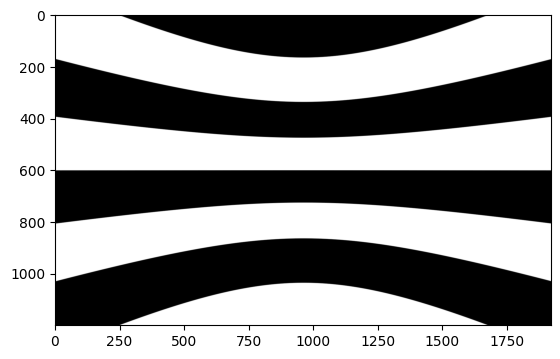

In [21]:
# Visualizing a particular stimulus
plt.imshow(behavior_session.stimulus_templates["warped"]["gratings_90.0"], cmap="gray")

As you can see, the `behavior_session` object has a lot of attributes and methods that can be used to access underlying data in the NWB file. Most of these will be touched on in other tutorials for [this data release](https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html).

Now let's see how to get data for a particular ophys experiment (i.e. imaging plane):

In [22]:
ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id=951980471)

behavior_ophys_experiment_951980471.nwb: 100%|██████████| 248M/248M [00:10<00:00, 22.8MMB/s]


In [23]:
# List methods of the ophys_experiment object that can be used to get data
print(ophys_experiment.list_data_attributes_and_methods())

['average_projection', 'behavior_session_id', 'cell_specimen_table', 'corrected_fluorescence_traces', 'demixed_traces', 'dff_traces', 'events', 'eye_tracking', 'eye_tracking_rig_geometry', 'get_cell_specimen_ids', 'get_cell_specimen_indices', 'get_dff_traces', 'get_performance_metrics', 'get_reward_rate', 'get_rolling_performance_df', 'get_segmentation_mask_image', 'licks', 'max_projection', 'metadata', 'motion_correction', 'neuropil_traces', 'ophys_experiment_id', 'ophys_session_id', 'ophys_timestamps', 'raw_running_speed', 'rewards', 'roi_masks', 'running_speed', 'segmentation_mask_image', 'stimulus_presentations', 'stimulus_templates', 'stimulus_timestamps', 'task_parameters', 'trials', 'update_targeted_imaging_depth']


Let's take a quick look at the max projection image for the optical physiology experiment (i.e. imaging plane) we just obtained:

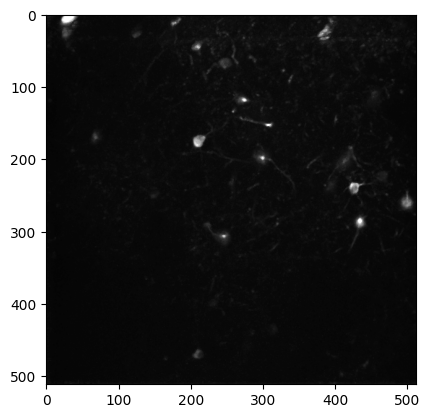

In [24]:
plt.imshow(ophys_experiment.max_projection, cmap="gray")

The `ophys_experiment` object has even more attributes and methods used to access NWB data! As with the `behavior_session` these methods will be touched on in other tutorials for [this data release](https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html).

## Downloading the complete dataset with AllenSDK

Analyzing one session or experiment at a time is nice, but in some cases you'll want to be able to perform an analysis across the whole dataset. To fill your cache with all available data, you can use a for loop like the one below.

Comment out the below code. Before running this code, please make sure that you have enough space available in your cache directory. You'll need around 437.6 GB for the behavior session NWB files, and another 563.2  GB if you're also downloading all ophys experiment NWB files.

In [25]:
# Remove rows from the behavior sessions table which don't correspond to a behavior session NWB file
filtered_behavior_sessions = behavior_sessions.dropna(subset=["file_id"])

if DOWNLOAD_COMPLETE_DATASET:
    for behavior_session_id, _ in filtered_behavior_sessions.iterrows():
        _ = cache.get_behavior_session(behavior_session_id=behavior_session_id)

    for ophys_experiment_id, _ in behavior_ophys_experiments.iterrows():
        _ = cache.get_behavior_ophys_experiment(ophys_experiment_id=ophys_experiment_id)

## Direct download of data from S3

If you do not wish to obtain data via the AllenSDK `VisualBehaviorOphysProjectCache` class, this section describes how to directly determine an S3 download link for your file or files of interest.

The S3 bucket that stores all the data for this project's release is:
<a href='https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/'>https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/</a>

The structure of the S3 bucket looks like:

```
visual-behavior-ophys/
│
├── release_notes.txt
│
├── manifests/
│   ├── visual-behavior-ophys_project_manifest_v{a.b.c}.json
│   ├── visual-behavior-ophys_project_manifest_v{x.y.z}.json
│   ...
│
├── project_metadata/
│   ├── behavior_session_table.csv
│   ├── ophys_experiment_table.csv
│   └── ophys_session_table.csv
│
├── behavior_sessions/
│   ├── behavior_session_{abc}.nwb
│   ├── behavior_session_{xyz}.nwb
│   ...
│
└── behavior_ophys_experiments/
    ├── behavior_ophys_experiment_{abc}.nwb
    ├── behavior_ophys_experiment_{xyz}.nwb
    ...
```

So if for example, you wanted to download a specific `behavior_ophys_experiment` you could first download the `ophys_experiment_table.csv` with:

<a href='https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/ophys_experiment_table.csv'>https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/ophys_experiment_table.csv</a> (try clicking me!)

Then using the table, determine the `ophy_experiment_id` you are interested in. Let's say we want `ophys_experiment_id = 951980471`, then the appropriate download link would be:

<a href='https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/behavior_ophys_experiments/behavior_ophys_experiment_951980471.nwb'>https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/behavior_ophys_experiments/behavior_ophys_experiment_951980471.nwb</a>

Below are some simple sample functions that will help you efficiently determine download URL links:

In [26]:
from urllib.parse import urljoin


def get_manifest_url(manifest_version: str) -> str:
    hostname = "https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/"
    object_key = f"visual-behavior-ophys/manifests/visual-behavior-ophys_project_manifest_v{manifest_version}.json"
    return urljoin(hostname, object_key)


# Example:
print(get_manifest_url("0.1.0"))

https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/manifests/visual-behavior-ophys_project_manifest_v0.1.0.json


In [27]:
def get_metadata_url(metadata_table_name: str) -> str:
    hostname = "https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/"
    object_key = f"visual-behavior-ophys/project_metadata/{metadata_table_name}.csv"
    return urljoin(hostname, object_key)


# Example:
print(get_metadata_url("behavior_session_table"))

https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/behavior_session_table.csv


In [28]:
def get_behavior_session_url(behavior_session_id: int) -> str:
    hostname = "https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/"
    object_key = f"visual-behavior-ophys/behavior_sessions/behavior_session_{behavior_session_id}.nwb"
    return urljoin(hostname, object_key)


# Example:
print(get_behavior_session_url(870987812))

https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/behavior_sessions/behavior_session_870987812.nwb


In [29]:
def get_behavior_ophys_experiment_url(ophys_experiment_id: int) -> str:
    hostname = "https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/"
    object_key = f"visual-behavior-ophys/behavior_ophys_experiments/behavior_ophys_experiment_{ophys_experiment_id}.nwb"
    return urljoin(hostname, object_key)


# Example:
print(get_behavior_ophys_experiment_url(951980471))

https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/behavior_ophys_experiments/behavior_ophys_experiment_951980471.nwb


## Downloading previous versions of released data from S3

AllenSDK makes uses of versioned manifest (JSON) files that live in the S3 bucket to keep track of EVERY version of a file for this data release. If a bug/error in the released data is discovered or new data is added to existing NWB files and the updated NWB file is uploaded in the future, a new manifest will be created pointing to the newest version of the file. The existing manifest will continue pointing at the original version allowing reproducibility of analysis results. You can think of each manifest as a snapshot of the state of the S3 bucket when the manifest was created.

This section describes how to download specific versions of a file in the S3 bucket.

### Listing and downloading a specific manifest version for the data release

If you have an AWS account (even a free tier account works) you can log in and access the bucket directly:

<a href='https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-ophys-data?prefix=visual-behavior-ophys/manifests/'>https://s3.console.aws.amazon.com/s3/buckets/visual-behavior-ophys-data?prefix=visual-behavior-ophys/manifests/</a>

If you don't have or don't want to use an AWS account you can click the following list to get an XML document:

<a href='https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/?list-type=2&prefix=visual-behavior-ophys/manifests/'>https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/?list-type=2&prefix=visual-behavior-ophys/manifests/</a>

Which will look like:
```
<ListBucketResult>
  <Name>visual-behavior-ophys-data</Name>
  <Prefix>visual-behavior-ophys/manifests/</Prefix>
  <KeyCount>1</KeyCount>
  <MaxKeys>1000</MaxKeys>
  <IsTruncated>false</IsTruncated>
  <Contents>
    <Key>
    visual-behavior-ophys/manifests/visual-behavior-ophys_project_manifest_v0.1.0.json
    </Key>
    <LastModified>2021-03-22T14:36:31.000Z</LastModified>
    <ETag>"8d10d6dd87234d4e0a1d400908c5013d"</ETag>
    <Size>1730897</Size>
    <StorageClass>STANDARD</StorageClass>
  </Contents>
</ListBucketResult>
```
The XML document is the result of a query which lists all manifests that currently exist for the data release (denoted with `<Key>` `</Key>`). To obtain a specific manifest of interest you just take the `Key` for the manifest you're interested in and append it to the name of the S3 bucket. For example:

<a href='https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/manifests/visual-behavior-ophys_project_manifest_v0.1.0.json'>https://visual-behavior-ophys-data.s3-us-west-2.amazonaws.com/visual-behavior-ophys/manifests/visual-behavior-ophys_project_manifest_v0.1.0.json</a>


### Using a versioned manifest to download a specific data version

Once you've downloaded a manifest, you can use it to obtain download links for the specific version of data files that the manifest tracks. The example function below loads a downloaded manifest and generates download links for *all* the metadata and data files for the specified manifest:

In [30]:
from typing import List
import json

# The location will differ based on where you downloaded the manifest.json!
my_manifest_location = output_dir / cache.latest_manifest_file()


def generate_all_download_urls_from_manifest(manifest_path: Path) -> List[str]:
    with manifest_path.open("r") as fp:
        manifest = json.load(fp)

    download_links = []

    # Get download links for specific version of metadata files
    for metadata_file_entry in manifest["metadata_files"].values():
        base_download_url = metadata_file_entry["url"]
        version_query = f"?versionId={metadata_file_entry['version_id']}"
        full_download_url = urljoin(base_download_url, version_query)
        download_links.append(full_download_url)

    # Get download links for specific version of data files
    for data_file_entry in manifest["data_files"].values():
        base_download_url = data_file_entry["url"]
        version_query = f"?versionId={data_file_entry['version_id']}"
        full_download_url = urljoin(base_download_url, version_query)
        download_links.append(full_download_url)

    return download_links


# Example:
print("\n".join(generate_all_download_urls_from_manifest(my_manifest_location)))

https://visual-behavior-ophys-data.s3.us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/behavior_session_table.csv?versionId=APZTq6fhaOTm7ii8OinG9EfONHc1f5CX
https://visual-behavior-ophys-data.s3.us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/ophys_session_table.csv?versionId=EZ90pl24aHpZH5EYT3nlkmYvYpiL1Zmf
https://visual-behavior-ophys-data.s3.us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/ophys_experiment_table.csv?versionId=eF5GLZ7pkfpxLPAf80fBw.u6XzIWULop
https://visual-behavior-ophys-data.s3.us-west-2.amazonaws.com/visual-behavior-ophys/project_metadata/ophys_cells_table.csv?versionId=ImGPmqF.DjxCoBwIwYaPJjWNqYrzIN6U
https://visual-behavior-ophys-data.s3.us-west-2.amazonaws.com/visual-behavior-ophys/behavior_sessions/behavior_session_870987812.nwb?versionId=J0U4MEYvNbBIOpPLZTde2BKoDzXaXwnu
https://visual-behavior-ophys-data.s3.us-west-2.amazonaws.com/visual-behavior-ophys/behavior_sessions/behavior_session_872953842.nwb?versionId=9eBP6